#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

<a name="outline"></a>

## Outline

- [Section 1](#section-1): Intro to kNN
- [Section 2](#section-2): Classification with kNN
- [Section 3](#section-3): Hyperparameter Tuning for $k$ with _T-fold_ Cross Validation
- [Section 4](#section-4): Regression with kNN


# _k_ nearest neighbours (kNN)

The purpose of this notebook is to understand and implement the kNN algorithm, without using any package that has a complete kNN framework already implemented (e.g., scikit-learn).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# fixing random generator for reproducibility
rng = np.random.default_rng(0)



<a name="section-1"></a>

## Section 1: Intro to kNN [^](#outline)

The kNN algorithm can be used both for classification and regression. Broadly speaking, it starts with calculating the distance of a given point $x$ to all other points in the data set. Then, it finds the _k_ nearest points closest to $x$, and assigns the new point $x$ to the majority class of the _k_ nearest points _(classification)_. So, for example, if two of the _k_=3 closest points to $x$ were red while one is blue, $x$ would be classified as red.

On the other hand in _regression_, we see the labels as continuous variables and assign the label of a data point $x$ as the mean of the labels of its _k_ nearest neighbours.

Important things first: You already know that the kNN algorithm is based on computing distances between data points. So, let's start with defining a function that computes such a distance. For simplicity, we will only work with **Euclidean distances** in this notebook, but other distances can be chosen interchangably, of course.

Implement in the following cell the Euclidean distance $d$, defined as
$$
d(\boldsymbol x^{(i)}, \boldsymbol x^{(j)}) = \sqrt{\sum_{m=1}^p{(x^{(i)}_m-x^{(j)}_m)^2}} \, ,
$$
where $\boldsymbol x^{(i)}$ and $\boldsymbol x^{(j)}$ are the two points in our $p$-dimensional Euclidean space.


In [ ]:
## EDIT THIS FUNCTION
def euclidean_distance(x_i, x_j):

    '''
    Argument:
    x_i: vector with shape (p,)
    x_j: matrix with shape (n, p)

    Returns:
    d: distance between x_i and each row of x_j
    '''

    assert x_j.shape[1] == x_i.shape[0]

    return np.sqrt(np.sum((x_i-x_j)**2, axis=1)) ## <-- SOLUTION

<a name="section-2"></a>

## Section 2: Classification with kNN [^](#outline)

We start with using kNN for classification tasks, and created a dataset with sklearn's [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function and standardise the variables in our data. By variable standardisation we intend subtracting to each variable its mean across samples (so the mean of the standardised variable is zero) and next dividing by the standard deviation across samples (so the standard deviation of the standardised variable is one).

In [ ]:
X = np.load("X_classification.npy")
y = np.load("y_classification.npy")

In [ ]:
## EDIT THIS FUNCTION
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True) ## <-- SOLUTION
    sigma = np.std(X_train_, axis=0, keepdims=True) ## <-- SOLUTION
    X_std = (X - mu) / sigma ## <-- SOLUTION
    return X_std

As with any other supervised machine learning method, we create a training and test set to learn and evaluate our model, respectively.

In [ ]:
# shuffling the rows in X and y
perm_ind = rng.permutation(len(y))
X = X[perm_ind]
y = y[perm_ind]

# we split train to test as 70:30
split_rate = 0.7
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

In [ ]:
# standardize train and test data
X_test = standardise(X_test, X_train_=X_train)
X_train = standardise(X_train)

We visualise the data set with points in the training set being fully coloured and points in the test being half-transparent.

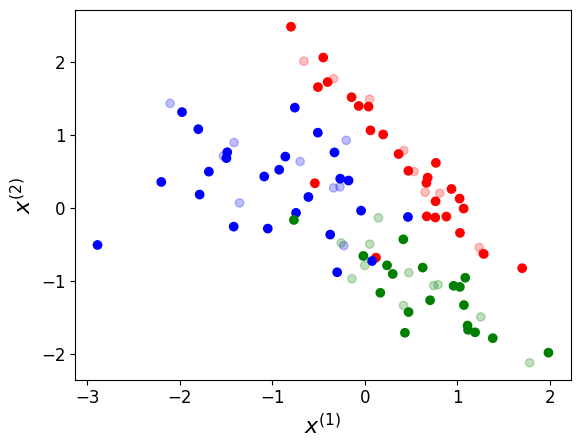

In [ ]:
# define colormaps
cm = plt.cm.RdBu
cm_bright = ListedColormap(['blue', 'red', 'green'])

# visual exploration
plt.figure()
plt.xlabel(r'$x^{(1)}$')
plt.ylabel(r'$x^{(2)}$')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.25)
plt.show()

We try to find the _k_ nearest neighbours in our training set for every test data point. The majority of labels of the _k_ closest training points determines the label of the test point.

In [ ]:
## EDIT THIS FUNCTION
def k_neighbours(X_train, X_test, k=5, return_distance=False):
  """
  This function finds the k nearest neighbours in X_train for each point in X_test .

  Argument:
  X_train: training data
  X_test: test data
  k: number of nearest neighbours
  return_distance: if True, return distances too

  Returns:
  np.array(neigh_ind): array of indices of k nearest neighbours

  """

  n_neighbours = k
  dist = []
  neigh_ind = []

  # compute distance from each point x_test in X_test to all points in X_train (hint: use python's list comprehension)
  point_dist = [euclidean_distance(x_test, X_train) for x_test in X_test] ## <-- SOLUTION

  # determine which k training points are closest to each test point
  for row in point_dist:
      enum_neigh = enumerate(row)
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

      ind_list = [tup[0] for tup in sorted_neigh]
      dist_list = [tup[1] for tup in sorted_neigh]

      dist.append(dist_list)
      neigh_ind.append(ind_list)

  # return distances together with indices of k nearest neighbours
  if return_distance:
      return np.array(dist), np.array(neigh_ind)

  return np.array(neigh_ind)

Once we know which _k_ neighbours are closest to our test points, we can predict the labels of these test points.

Our `predict` function determines how any point $x_\text{test}$ in the test set is classified. Here, we only consider the case where each of the *k* neighbours contributes equally to the classification of $x_\text{test}$.

In [ ]:
## EDIT THIS FUNCTION
def predict(X_train, y_train, X_test, k=5):
  """
  This function predicts labels of test data given training data and labels.

  Argument:
  X_train: training data
  y_train: training labels
  X_test: test data
  k: number of nearest neighbours

  Returns:
  y_pred: predicted labels for X_test

  """
  # each of the k neighbours contributes equally to the classification of any data point in X_test
  neighbours = k_neighbours(X_train, X_test, k=k)
  # count number of occurences of label with np.bincount and choose the label that has most with np.argmax (hint: use python's list comprehension)
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours]) ## <-- SOLUTION

  return y_pred

To evaluate the algorithm in a more principled way, we need to implement a function that computes the mean accuracy by counting how many of the test points have been classified correctly and dividing this number by the total number of data points in our test set.

Again, we do this is in a pythonic way and call the previous `predict` function _within_ the next function `score`.

In [ ]:
## EDIT THIS FUNCTION
def score(X_train, y_train, X_test, y_test, k=5):

  y_pred = predict(X_train, y_train, X_test, k=k) ## <-- SOLUTION

  return float(sum(y_pred==y_test))/ float(len(y_test))

It is quite common to print both the training and test set accuracies.

In [ ]:
k = 8
print('Training set mean accuracy:', score(X_train, y_train, X_train, y_train, k=k))
print('Test set mean accuracy:', score(X_train, y_train, X_test, y_test, k=k))

Training set mean accuracy: 0.8857142857142857
Test set mean accuracy: 0.9333333333333333


#### Questions
1. Does the solution above look reasonable?
2. Play around with different values for _k_. How does it influence the classification mean accuracy?
3. Compare the training and test set accuracy. Is there a difference? If so, what does the difference tell you?
4. Choose different ratios for the split between training and test set, and re-run the entire algorithm. What can you learn from different ratios?
5. Considering an accuracy estimate on a test-split wich contains 30% of the dataset examples is 0.86, do we guarantee to obtain the same accuracy estimate when we apply our model on infinetely large unseen test examples, i.e. does the accuracy of your model on the test-split generalize well on unseen data? From this week's lecture notes, what would you suggest to improve our confidence in the accuracy estimate, so it is a closer estimate to the true accuracy when testing on unseen examples?

<a name="section-3"></a>

### 3 Hyperparameter Tuning for $k$ with _T-fold_ Cross [^](#outline)

Let's consider a systematic way to help select the best $k$ (i.e. the hyperparameter of $k$-NN). In previous cells, we splitted our data into 70%:30% for training:test examples. Now we need to choose the best $k$, but without looking at the accuracy on the test set (which should be used at the end to assess the predictive power of the model with the chosen $k$). To this end, we perform $T$-fold cross validation, where, **importantly**, we don't evaluate the accuracy of the model using the same examples on which we trained our model, rather on a held out validation set. We can achieve this by running $T$ experiments, and in each one we use disjoint partitions for the training and accuracy examples. By averaging the accuracy estimates over the $T$ experiments, we get a more precise and reliable accuracy estimate than before. If we consider $T=3$ folds, then we can run the three experiments and evaluate the average accuracy as in the figure below:

![cv](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/cv1.png)


Finaly, we need to isolate a separate set, before using cross-validation for hyperparameter tuning, to test our model after selecting the best performing $k$ for $k$-NN, so we further consider the following partitioning, which we will need to adhere with throughout the future notebooks and courseworks (i.e. in the problems when we need to use cross-validation for hyperparameter tuning then test on completely unseen data that are not involved in hyperparamter tuning):

![cv2](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/cv2.png)



Let's consider a ratio 80:20 for training and test splits. Before splitting, it is good practice to reshuffle the data in case they were grouped by label/outcome in some way, in such a way that after splitting the training/validation/test data are as statistically equivalent as possible.

In [ ]:
# shuffling the rows in X and y
perm_ind = rng.permutation(len(y))
X = X[perm_ind]
y = y[perm_ind]

# we split train to test as 80:20
split_rate = 0.8
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

In [ ]:
# standardize train and test data
X_test = standardise(X_test, X_train_=X_train)
X_train = standardise(X_train)

Now let's partition our training split into 5-folds. We could store the corresponding indices only:

In [ ]:
# Now we have a list of five index arrays, each correspond to one of the five folds.
folds_indexes = np.split(np.arange(len(y_train)), 5)
folds_indexes

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
 array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])]

Let's implement a function that evalutes the accuracy of model with a given $k$ by running $T$ experiments and returning the average evaluated accuracy.

In [ ]:
# EDIT THIS FUNCTION
def cross_validation_score(X_train, y_train, folds, k):
  scores = []
  for i in range(len(folds)):
    val_indexes = folds[i]
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]

    X_val_i = X_train[val_indexes, :] # <- SOLUTION
    y_val_i = y_train[val_indexes] # <- SOLUTION

    score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k) # <- SOLUTION
    scores.append(score_i)

  # Return the average score
  return sum(scores) / len(scores) # <- SOLUTION

Let's scan a range of $k$ in $[1, 30]$ and select the one with the best cross-validation accuracy.

In [ ]:
def choose_best_k(X_train, y_train, folds, k_range):
  k_scores = np.zeros((len(k_range),))

  for i, k in enumerate(k_range):
    k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
    print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

  best_k_index = np.argmax(k_scores)
  return k_scores, k_range[best_k_index]

In [ ]:
k_scores, best_k = choose_best_k(X_train, y_train, folds_indexes, np.arange(1, 31))

print('best_k:', best_k)

CV_ACC@k=1: 0.838
CV_ACC@k=2: 0.850
CV_ACC@k=3: 0.900
CV_ACC@k=4: 0.900
CV_ACC@k=5: 0.938
CV_ACC@k=6: 0.912
CV_ACC@k=7: 0.900
CV_ACC@k=8: 0.900
CV_ACC@k=9: 0.887
CV_ACC@k=10: 0.887
CV_ACC@k=11: 0.887
CV_ACC@k=12: 0.875
CV_ACC@k=13: 0.863
CV_ACC@k=14: 0.850
CV_ACC@k=15: 0.850
CV_ACC@k=16: 0.850
CV_ACC@k=17: 0.875
CV_ACC@k=18: 0.875
CV_ACC@k=19: 0.863
CV_ACC@k=20: 0.863
CV_ACC@k=21: 0.863
CV_ACC@k=22: 0.863
CV_ACC@k=23: 0.838
CV_ACC@k=24: 0.850
CV_ACC@k=25: 0.850
CV_ACC@k=26: 0.838
CV_ACC@k=27: 0.838
CV_ACC@k=28: 0.825
CV_ACC@k=29: 0.812
CV_ACC@k=30: 0.800
best_k: 5


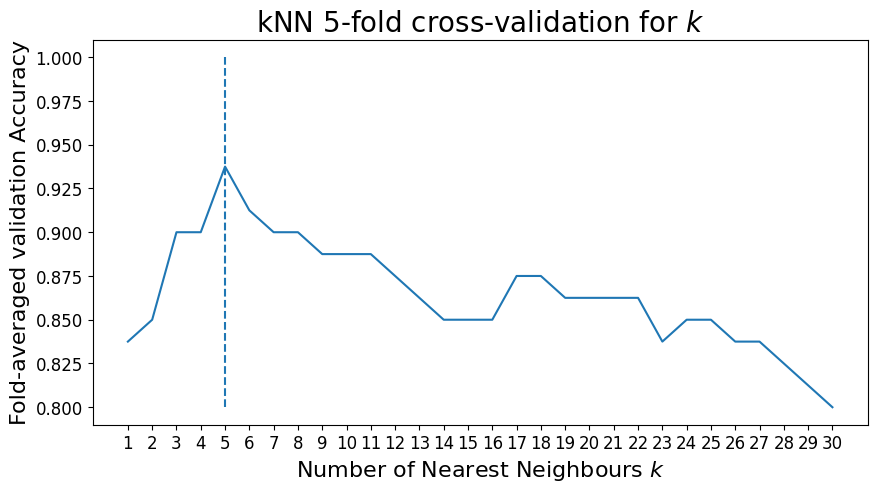

In [ ]:
#Plot the cross-validation scores as a function of k

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 31), k_scores)
plt.xlabel(r'Number of Nearest Neighbours $k$')
plt.ylabel(r'Fold-averaged validation Accuracy')
plt.vlines(x=best_k, ymin=min(k_scores), ymax=1, linestyles='dashed')
plt.xticks(np.arange(1, 31))
plt.title(r"kNN 5-fold cross-validation for $k$")
plt.show()

Finally, let's evaluate the accuracy with the best k on on the unseen part, the test-split that we isolated earlier.

In [ ]:
score(X_train, y_train, X_test, y_test, k=best_k)

0.85


<a name="section-4"></a>

## Section 4:  Regression with kNN [^](#outline)

The kNN algorithm is mostly used for classification, but we can also utilise it for (non-linear) regression. Here, we calculate the label of every point in the test set as the mean of the _k_ nearest neighbours.

We start with a training set from sklearn's California housing data set. Note that this data set has normally 8 features, but we only extract the first feature, which corresponds to the median income in the district. The label is the median house value in the district.


In [ ]:
X = np.load("X_housing.npy")
y = np.load("y_housing.npy")

As before, we first divide the data into training and test set:

In [ ]:
# shuffling the rows in X and y
perm_ind = rng.permutation(len(y))
X = X[perm_ind]
y = y[perm_ind]

# we split train to test as 70:30
split_rate = 0.7
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

In [ ]:
# standardize train and test data
X_test = standardise(X_test, X_train_=X_train)
X_train = standardise(X_train)

Let's plot it to get a sense how we can proceed. This time, we plot training examples in blue and test examples in red.

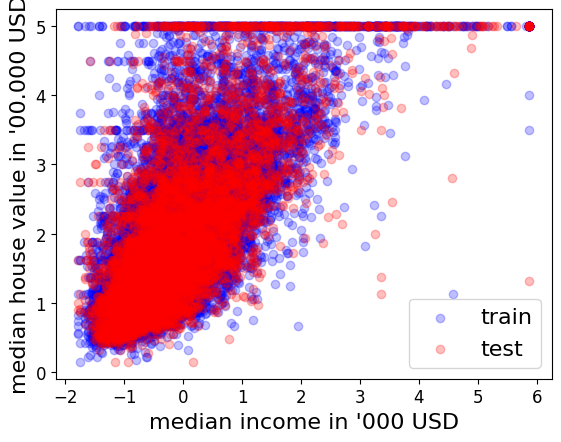

In [ ]:
# visual exploration
plt.xlabel(r"median income in '000 USD")
plt.ylabel(r"median house value in '00.000 USD")
plt.scatter(X_train, y_train, c='blue', label='train', alpha=0.25)
plt.scatter(X_test, y_test, c='red', label='test', alpha=0.25)
plt.legend()
plt.show()

As before, we need to define a predicting function which we call `reg_predict`.

In [ ]:
## EDIT THIS FUNCTION
def reg_predict(X_train, y_train, X_test, k=20):

  # each of the k neighbours contributes equally to the classification of any data point in X_test
  neighbours = k_neighbours(X_train, X_test, k=k)
  # compute mean over neighbours labels (hint: use python's list comprehension)
  y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours]) ## <-- SOLUTION

  return y_pred

In [ ]:
# computing predictions... (takes a few minutes due to the high sample size)
k = 20
y_pred = reg_predict(X_train, y_train, X_test, k=k)

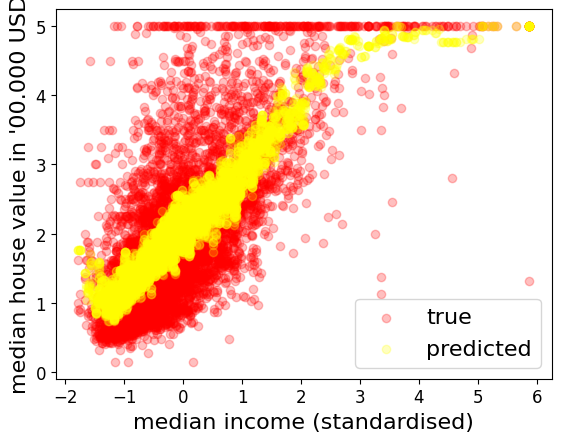

In [ ]:
# ... and plotting them
plt.xlabel(r"median income (standardised)")
plt.ylabel(r"median house value in '00.000 USD")
#plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', label='true', alpha=0.25)
plt.scatter(X_test, y_pred, c='yellow', label='predicted', alpha=0.25)
plt.legend()
plt.show()

To determine how well the prediction was, let us determine the $R^2$ score. The labels of the test set will be called $y$ and the predictions on the test data $\hat{y}$.
$$
R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2} \, ,
$$
where $\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$.

In [ ]:
## EDIT THIS FUNCTION
def r2_score(y_test, y_pred):
  numerator = np.sum((y_test - y_pred)**2) ## <-- SOLUTION
  y_avg = np.mean(y_test) ## <-- SOLUTION
  denominator = np.sum((y_test - y_avg)**2) ## <-- SOLUTION
  return 1 - numerator/denominator

In [ ]:
print(r'R2 score:', r2_score(y_test, y_pred))

R2 score: 0.47321910880219065


Extra: weighted kNN

In [ ]:
## EDIT THIS FUNCTION
def reg_predict_w(X_train, y_train, X_test, k=20):

  # each of the k neighbours contributes equally to the classification of any data point in X_test
  distances, neighbours = k_neighbours(X_train, X_test, k=k, return_distance=True)
  # compute mean over neighbours labels (hint: use python's list comprehension)
  y_pred = np.array([
      np.sum((y_train[neighbour] / (distances[idx]+1e-7))) / np.sum(1/(distances[idx]+1e-7))
      for idx, neighbour in enumerate(neighbours)

  ]) ## <-- SOLUTION

  return y_pred

In [ ]:
k = 20
y_pred = reg_predict_w(X_train, y_train, X_test, k=k)

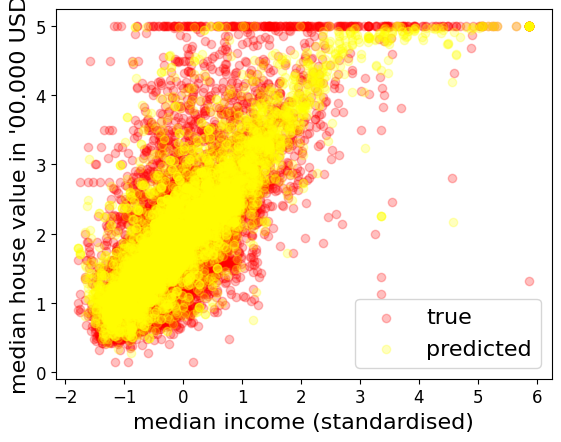

In [ ]:
# ... and plotting them
plt.xlabel(r"median income (standardised)")
plt.ylabel(r"median house value in '00.000 USD")
#plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', label='true', alpha=0.25)
plt.scatter(X_test, y_pred, c='yellow', label='predicted', alpha=0.25)
plt.legend()
plt.show()

#### Questions
1. Does the solution above look reasonable? What does your $R^2$ value tell you?
2. Play around with different values for _k_. How does it influence the regression?
3. Like we did in classification, excercise with implementing cross-validation to find the best performing k on the regression task.
4. Compare the training and test set accuracy. Is there a difference? If so, what does the difference tell you?
5. Choose different ratios for the split between training and test set, and re-run the entire algorithm. What can you learn from different ratios?
6. Can you replicate your results using [sklearn](https://scikit-learn.org/stable/modules/neighbors.html)?
7. Based on sklearn's documentation, can you see any differences in the algorithms that are implemented in sklearn?